# Feedforward Neural Network Image Classification: MNIST
In this notebook, a Feedforward Neural Network will be build from scratch and trained on the MNIST dataset. The MNIST dataset is a dataset containing hand-written images of digits. The end goal is to label the images with their corresponding digit. 

## Import Libraries

In [1]:
import torch
import torch.nn as nn 
from torch.optim import SGD 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassAccuracy 
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

c:\Users\Quinten Danneels\Documents\WP2 notebooks\Test\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The MNIST Dataset
In this part, the dataset is loaded and a preview of an image is shown.

The training set is loaded in this cell, where x denotes the input images and y the corresponding labels.

In [2]:
x, y = torch.load("MNIST\\MNIST\\processed\\training.pt") #change to the directory of the notebooks

The shape of x shows us that the training set is composed of 6000 28x28 images

In [3]:
x.shape 

torch.Size([60000, 28, 28])

i denotes a random sample from the MNIST dataset. A plot is created of that random sample with its corresponding digit.

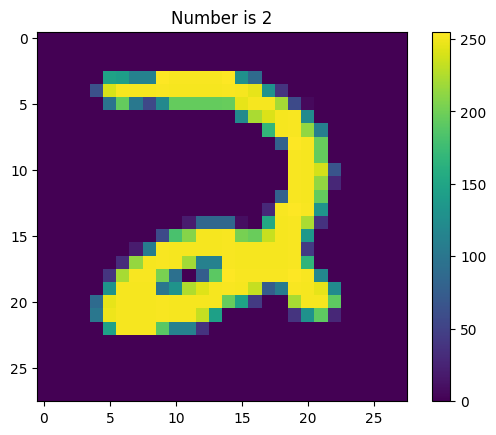

In [4]:
i = random.randint(0, 59999)

plt.imshow(x[i].numpy())
plt.title(f'Number is {y[i].numpy()}')
plt.colorbar()
plt.show()

## Data Preparation

### One-hot Encoding
The labels provided in the MNIST dataset will be transformed to a one-hot encoding representation of that label. This is needed to be compatible with the Feedforward Neural network that we will build. The one-hot encoding is a 1 x n vector where the i-th element (corresponding to a specific label) is 1 and the other values are 0. This can be seen as a vector of probabilities (1 = 100% chance of being that label, 0 = 0% chance of being that label). 

In [5]:
y_example = torch.tensor([2, 1, 4, 0])
y_encoding = F.one_hot(y_example, num_classes=5)

print(y_encoding)

tensor([[0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0]])


In [6]:
y_new = F.one_hot(y, num_classes=10)

print(y_new)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])


### Images Transformation
The images are currently 28 x 28 matrices. But if we want to present them to the Feedforward Neural Network, we have to turn them into vectors of size 28².

In [7]:
x.view(-1, 28**2).shape # -1 means that the first dimension size is preserved. This is 6000 (= the amount of training images)

torch.Size([60000, 784])

## PyTorch Dataset Object
In this part, a class will be created for the datasets. This class will contain Python functions such as length of the dataset and get the specific item (=slicing) from the dataset.

This class will transform the original pixel value range from 0->255 to 0->1 and the labels will be transformed to a one-hot encoding presentation.

In [8]:
class CTDataset(Dataset):
    def __init__(self, data):
        self.x, self.y = data
        self.x = self.x/ 255.
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [9]:
train_set = torch.load("MNIST\\MNIST\\processed\\training.pt")
test_set = torch.load("MNIST\\MNIST\\processed\\test.pt")

train_ds, val_ds = random_split(CTDataset(train_set),[50000,10000])
dataset_sizes = {'train':50000,'val':10000}
test_ds = CTDataset(test_set)

## PyTorch DataLoader Object
The Dataset objects can be put inside a DataLoader class. This is very useful because batches can be created with this class. Batches of data samples are useful during the training process. 

This will create batches of 5 digit images. The length of the Dataloader object will be 60000/5=12000. 

In [10]:
train_dl = DataLoader(train_ds, batch_size=5)
val_dl = DataLoader(val_ds, batch_size=5)

dataloaders = {'train': train_dl, 'val': val_dl}

len(train_dl), len(val_dl)

(10000, 2000)

## The Feedforward Neural Network Architecture
In this section, a class object of the Neural Network will be created. In this example, the first layer transforms 28² elements to 100 elements. The second layer transforms 100 elements to 50 elements. The last layer transforms 50 elements to 10 elements. These 10 elements represent the probabilities of being the i-th digit of the vector.

In [11]:
class FFNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 100)
        self.Matrix2 = nn.Linear(100, 50)
        self.Matrix3 = nn.Linear(50, 10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1, 28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [12]:
model = FFNeuralNet()

## Training
A function is created to automize the training of the Feedforward Neural Network. 

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
def train_model(model, criterion, optimizer, n_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())  # takes a copy of the model and also of all the inner layers, weights, biases
    best_acc = 0.0

    # Train loop
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs-1))
        print('-'*10)

        # each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # store the inputs to the selected device
                labels = labels.to(device)  # store the labels to the selected device

                # forward step
                with torch.set_grad_enabled(phase=='train'):    # gradient calculation will only be enabled when in training mode
                    outputs = model(inputs)
                    preds = torch.max(outputs)
                    _, preds = torch.max(outputs,-1)    # get the indices of the max values --> prediction
                    _, labels = torch.max(labels,-1)    # get the indices of the max values (one-hot encoding) --> label
                    loss = criterion(outputs, labels)

                    # backward step and optimise only in train phase
                    if phase=='train':
                        optimizer.zero_grad()   # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                        loss.backward()
                        optimizer.step()    # update the model parameters using the defined optimizer 
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data) 
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            # deep copy the model
            if phase=='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            print()

    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return train_losses, val_losses

In [15]:
optimizer = SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
epochs = 50
train_losses, val_losses = train_model(model,criterion,optimizer,n_epochs=epochs)

epoch = list()
for i in range(epochs):
    epoch.append(i)

Epoch 0/49
----------
train Loss: 1.7172 Acc: 0.5105

val Loss: 0.7942 Acc: 0.8070

Epoch 1/49
----------
train Loss: 0.5461 Acc: 0.8551

val Loss: 0.4281 Acc: 0.8819

Epoch 2/49
----------
train Loss: 0.3854 Acc: 0.8913

val Loss: 0.3617 Acc: 0.8988

Epoch 3/49
----------
train Loss: 0.3367 Acc: 0.9033

val Loss: 0.3291 Acc: 0.9070

Epoch 4/49
----------
train Loss: 0.3073 Acc: 0.9113

val Loss: 0.3061 Acc: 0.9145

Epoch 5/49
----------
train Loss: 0.2854 Acc: 0.9168

val Loss: 0.2877 Acc: 0.9200

Epoch 6/49
----------
train Loss: 0.2673 Acc: 0.9224

val Loss: 0.2719 Acc: 0.9230

Epoch 7/49
----------
train Loss: 0.2515 Acc: 0.9272

val Loss: 0.2581 Acc: 0.9264

Epoch 8/49
----------
train Loss: 0.2375 Acc: 0.9319

val Loss: 0.2456 Acc: 0.9296

Epoch 9/49
----------
train Loss: 0.2248 Acc: 0.9352

val Loss: 0.2343 Acc: 0.9330

Epoch 10/49
----------
train Loss: 0.2132 Acc: 0.9386

val Loss: 0.2241 Acc: 0.9374

Epoch 11/49
----------
train Loss: 0.2025 Acc: 0.9420

val Loss: 0.2146 Acc

The validation loss function is plotted for each epoch during the training procedure.

Text(0.5, 1.0, 'Cross entropy(per batch)')

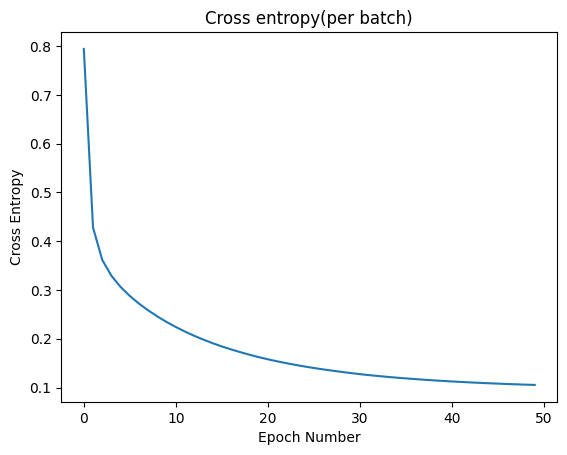

In [17]:
plt.plot(epoch, train_losses, label="Train loss")
plt.plot(epoch, val_losses, label="Validation loss")
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross entropy(per batch)')

It is clear that the loss becomes smaller as the amount of epochs progresses. The validation loss keeps decreasing, thus overfitting does not occur here.

## Predicting using the Trained Feedforward Neural Network

The actual label of the sample image:

In [18]:
y_sample = train_ds[0][1]
y_sample

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64)

The predicted label of the sample image:

In [19]:
x_sample = train_ds[0][0]
y_pred_sample = model(x_sample)
y_pred_sample

tensor([ 0.2102, -6.4472,  9.4185, -2.5249,  6.4897,  2.3015, 13.9090, -4.8509,
        -4.2132, -9.7246], grad_fn=<SqueezeBackward0>)

The predicted label is not normalised, therefore we should look at the maximum value of the prediction.

In [20]:
torch.argmax(y_pred_sample)

tensor(6)

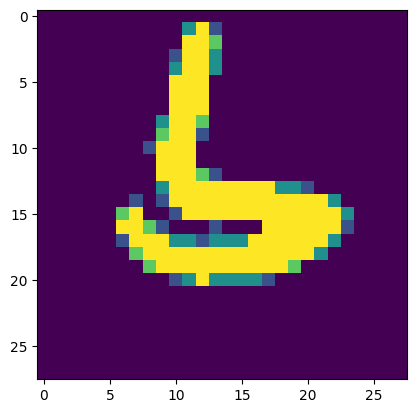

In [21]:
plt.imshow(x_sample)

Next, some more predictions are looked at. A sub dataset of 2000 image samples is created. 

In [22]:
xs, ys = train_ds[0:2000]

The predicted labels using the trained Neural Network are computed below:

In [23]:
ys_pred = model(xs).argmax(axis=1)

Plot 40 predictions:

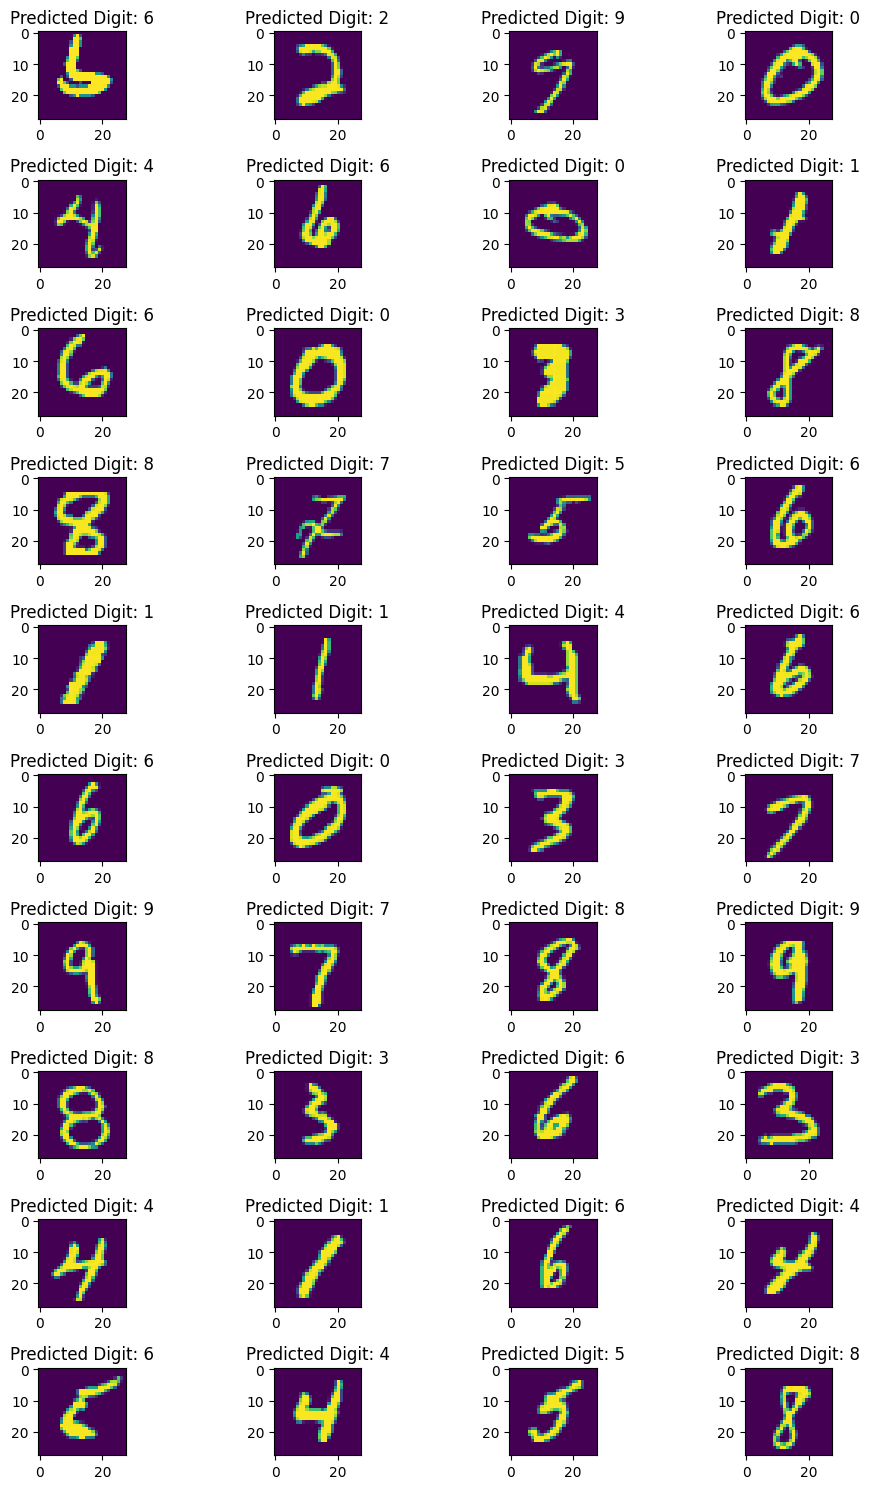

In [24]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {ys_pred[i]}')
fig.tight_layout()
plt.show()

Untill now, we have only looked at the predictions of training samples. To check the generalizability of the trained Neural Network, the predictions of the test dataset are looked at:

In [25]:
xs, ys = test_ds[:2000]
ys_pred = model(xs).argmax(axis=1)


Plot 40 predictions:

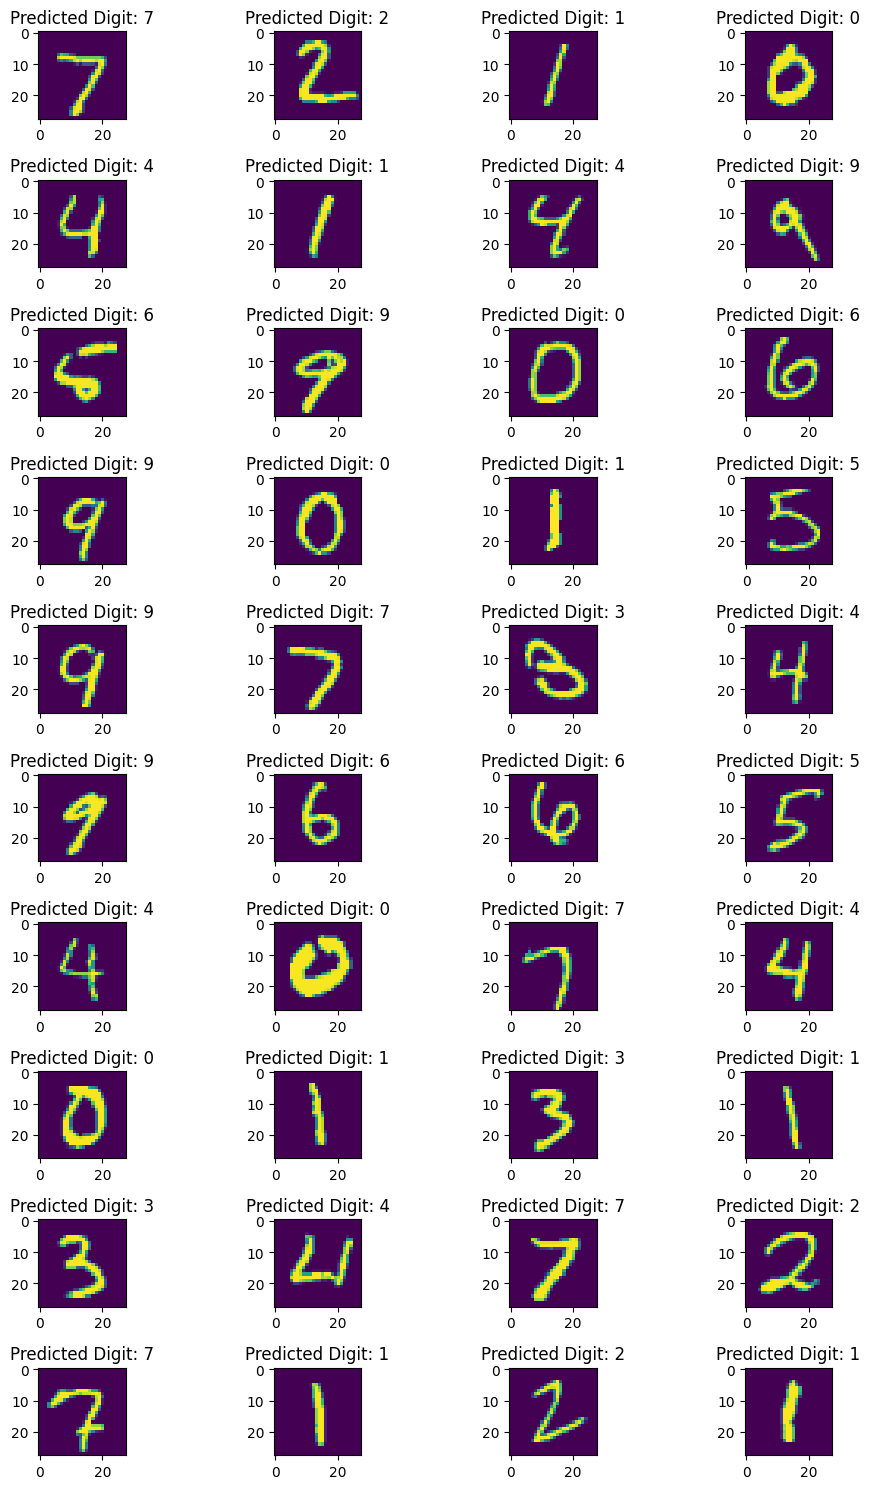

In [26]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {ys_pred[i]}')
fig.tight_layout()
plt.show()

The trained Neural Network also performs very well on the test data samples. 

## Evaluation

In [27]:
ys = ys.argmax(axis=1)
ys

tensor([7, 2, 1,  ..., 3, 9, 5])

The simple evaluation metric accuracy is used.

In [28]:
metric = MulticlassAccuracy(num_classes=10)
metric(ys_pred, ys)

tensor(0.9630)

The accuracy of 2000 images of the test dataset is above 95% (tensor(0.95)), which is very high. 